# Alzheimer MRI Pytorch Lightning AlexNet

In [13]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

In [15]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees, add diversity to the image + more patterns
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],#normalise pixel value to make everything similar and thus easier to read
                             [0.229, 0.224, 0.225]) #transform all the images to the same size

])

In [16]:
dataset0=datasets.ImageFolder(root="/Users/annabelleyao/Desktop/MRIdataset",transform=None)
print(len(dataset0))
class_names=dataset0.classes
print(class_names)
print(len(class_names))

6400
['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
4


In [17]:
class DataModule(pl.LightningDataModule): #reusable class that contains all the steps needed to process data, handle data processes
    from sklearn.model_selection import train_test_split
    def __init__(self, transform=transform, batch_size=64): #initialise each dataset
        super().__init__()
        self.root_dir = "/Users/annabelleyao/Desktop/MRIdataset"
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None): #initialising the processes
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data) #percentage used to train vs test
        n_test = n_data - n_train
        # train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test]) #randomise the images chosen according to previous numbers

        # train_dataset =torch.utils.data.Subset(dataset, range(0, n_train))
        # test_dataset =torch.utils.data.Subset(dataset, range(n_train, len(dataset)))
        # self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        # self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size)
        ## sample based on random index and save index, will result in different train and test indices
        ## sample based on random index and save index
        if not os.path.exists("train_indices.txt"):
            indices = list(range(n_data))
            random.shuffle(indices)
            train_indices = indices[:n_train]
            test_indices = indices[n_train:]
                    ## save indices
            with open("train_indices.txt", "w") as f:
                for idx in train_indices:
                    f.write(str(idx) + "\n")
            with open("test_indices.txt", "w") as f:
                for idx in test_indices:
                    f.write(str(idx) + "\n")
        else:
            with open("train_indices.txt", "r") as f:
                train_indices = [int(idx.strip()) for idx in f.readlines()]
            with open("test_indices.txt", "r") as f:
                test_indices = [int(idx.strip()) for idx in f.readlines()]
        ## create sampler
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SubsetRandomSampler(test_indices)
        # ## create dataloader
        self.train_dataset = DataLoader(dataset, batch_size=self.batch_size, sampler=train_sampler)
        self.test_dataset = DataLoader(dataset, batch_size=self.batch_size, sampler=test_sampler)
        # train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test]) #randomise the images chosen according to previous numbers

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset

In [18]:
class MyModel(LightningModule):

    def __init__(self): #initialize model, add layer add here
        super().__init__()
        self.model = models.alexnet(pretrained=True)
        self.model.classifier = nn.Sequential( nn.Linear(9216,1024), #2 levels of functions, add layer here
                                             nn.ReLU(), #activation function
                                             nn.Dropout(p=0.5), #trick to increase generalisability of CNN, p is probability
                                             #used to using p probability random select neurons, only use selected neurons to do next step 
                                             #------------level split here
                                             nn.Linear(1024,512), 
                                             nn.ReLU(), #activation function
                                             nn.Dropout(p=0.5), 
                                             nn.Linear(512,len(class_names)), #output must always be number of classes
                                             nn.LogSoftmax(dim=1)) #following input tensor dimension, one instance has 4 neurons that add to 1
        print(self.model)    

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001) # adam type optimizer// optimize defining paramater groups, learning rate
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True) #prediction, argmax because each tensor's probability and trying to find largest probability
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [19]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model = MyModel()
    trainer = pl.Trainer(max_epochs=30)
    trainer.fit(model, datamodule)

/Users/annabelleyao/opt/anaconda3/envs/jpnbenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/annabelleyao/opt/anaconda3/envs/jpnbenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/annabelleyao/opt/anaconda3/envs/jpnbenv/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You de

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 80/80 [02:10<00:00,  1.64s/it, v_num=17]


In [23]:
datamodule.setup(stage='test')
test_loader = datamodule.test_dataloader()
trainer.test(dataloaders=test_loader)

/Users/annabelleyao/opt/anaconda3/envs/jpnbenv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /Users/annabelleyao/Desktop/lightning_logs/version_17/checkpoints/epoch=29-step=2400.ckpt
Loaded model weights from the checkpoint at /Users/annabelleyao/Desktop/lightning_logs/version_17/checkpoints/epoch=29-step=2400.ckpt
/Users/annabelleyao/opt/anaconda3/envs/jpnbenv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num

Testing DataLoader 0: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.635937511920929
        test_loss           0.7900615930557251
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7900615930557251, 'test_acc': 0.635937511920929}]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([2, 3, 3, 2, 2, 0, 3, 3, 3, 0, 3, 3, 2, 2, 2, 3, 3, 1, 3, 2, 3, 0, 2, 3,
        0, 3, 3, 0, 2, 2, 3, 2, 0, 2, 3, 3, 2, 2, 0, 2, 3, 2, 3, 0, 2, 2, 3, 2,
        3, 2, 3, 2, 3, 2, 3, 2, 0, 2, 3, 0, 2, 2, 3, 0])


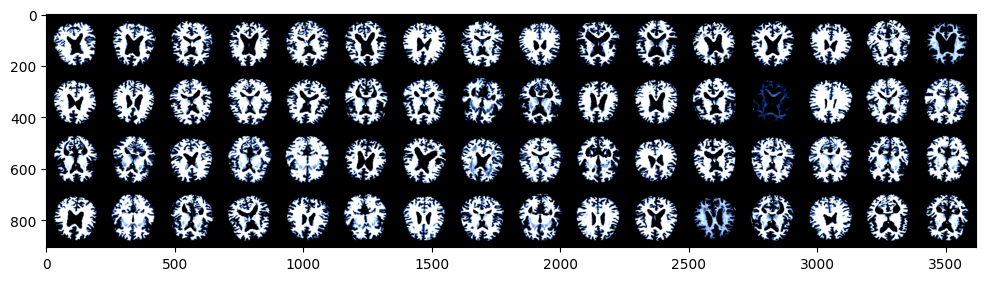

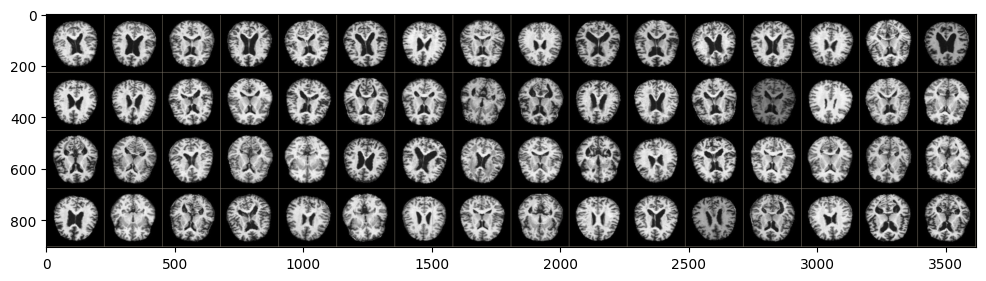

In [24]:
for images, labels in datamodule.train_dataloader():
    print(labels)
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0))) #original images

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225], #, using the Imagenet pretrianed model with its own mean and std is recommended.
                                   std=[1/0.229,1/0.224,1/0.225]) #normalise images
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0))) #after transformation, normalised

In [25]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report, auc, recall_score, precision_score, precision_recall_curve

model.eval()
y_true=[]
y_pred=[]
y_prob=[]
y_onehot=[]

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        probs = model(test_images)
        probs = torch.exp(probs)
        y_true2 = np.array(test_labels).reshape(-1, 1)
        encoder = OneHotEncoder(sparse=False, categories=[range(4)])
        # Fit and transform the list to one-hot encoding
        onehot = encoder.fit_transform(y_true2)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())
            y_prob.append(probs[i].numpy())
            y_onehot.append(onehot[i])

# Calculate ROC AUC
roc_auc = roc_auc_score(y_onehot, y_prob)
print("ROC AUC:", roc_auc)

# Calculate classification report
class_names = ["class1", "class2", "class3", "class4"]
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("Classification Report:")
print(report)


/Users/annabelleyao/opt/anaconda3/envs/jpnbenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/annabelleyao/opt/anaconda3/envs/jpnbenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/annabelleyao/opt/anaconda3/envs/jpnbenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/annabelleyao/opt/anaconda3/envs/jpnbenv/lib/python3.11/site-packages/sklear

ROC AUC: 0.8463094603002066
Classification Report:
              precision    recall  f1-score   support

      class1     0.5895    0.2745    0.3746       204
      class2     0.0000    0.0000    0.0000        12
      class3     0.7676    0.7540    0.7607       622
      class4     0.5157    0.6697    0.5827       442

    accuracy                         0.6414      1280
   macro avg     0.4682    0.4246    0.4295      1280
weighted avg     0.6450    0.6414    0.6306      1280



/Users/annabelleyao/opt/anaconda3/envs/jpnbenv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/annabelleyao/opt/anaconda3/envs/jpnbenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annabelleyao/opt/anaconda3/envs/jpnbenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)